# Toy Problem 2: Grid Outline

In [47]:
import networkx as nx
import math
import pandas as pd
import random
import osmnx as ox
import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import itertools
import numpy as np

Create 3x3 grid graph

In [48]:
G = nx.grid_2d_graph(4, 4)  # 3x3 grid

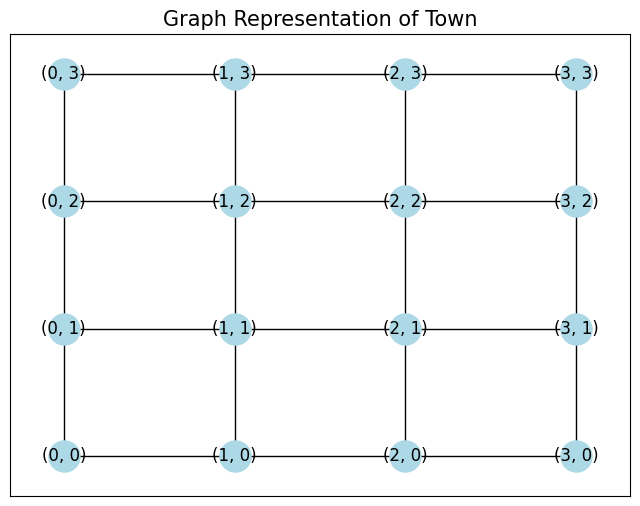

In [49]:


node_positions = {(x,y):(x,y) for x,y in G.nodes()}

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos=node_positions, node_size=500, node_color='lightblue', with_labels=True)
plt.title('Graph Representation of Town', size=15)
plt.show()

### Add edge and node attributes

In [62]:
# add an attribute called distance to each edge set to 1
for u, v, d in G.edges(data=True):
    d['distance'] = 1
    d['passes_rem'] = 1
    d['priority'] = 1
    d['salt_per'] = 1
    d['deadheading_passes'] = 1

Set the effective degree of all nodes. If $v$ is the vertice and $E_v$ is the set of all edges leaving from $v$, then the effective degree is 
$$\text{Deg(v)} = \sum_{e \in E_v} e(\text{passes})$$

In [63]:
for node in G.nodes:
    eff_deg = 0
    for edge in G.edges([node], data=True):
        eff_deg += edge[2]['passes_rem']
    G.nodes[node]['effective_degree'] = eff_deg
# print result
    
for edge in G.edges(data=True):
    edge[2]['salt_tot'] = edge[2]['passes_rem']*edge[2]['salt_per']
for node in G.nodes(data=True):
    print(node)


((0, 0), {'effective_degree': 2})
((0, 1), {'effective_degree': 3})
((0, 2), {'effective_degree': 3})
((0, 3), {'effective_degree': 2})
((1, 0), {'effective_degree': 3})
((1, 1), {'effective_degree': 4})
((1, 2), {'effective_degree': 4})
((1, 3), {'effective_degree': 3})
((2, 0), {'effective_degree': 3})
((2, 1), {'effective_degree': 4})
((2, 2), {'effective_degree': 4})
((2, 3), {'effective_degree': 3})
((3, 0), {'effective_degree': 2})
((3, 1), {'effective_degree': 3})
((3, 2), {'effective_degree': 3})
((3, 3), {'effective_degree': 2})


## Route Construction

Calculate shortest distance between each pair of nodes in the network using
Floyd's algorithm and visualize distance matrix

Define a cost function for traversing an arc

In [64]:
def cost(G, node1, node2):
    '''
    Returns the cost of traversing an edge between two nodes. Doesn't include priorities yet. 
    Currently based solely on distance.
    '''
    edge_data = G.get_edge_data(node1, node2)

    cost = edge_data['distance']
    return cost

In [65]:
def needs_servicing(G, node1, node2):
    '''
    Returns whether or not the edge between two nodes requires servicing
    '''
    return G[node1][node2]['passes_rem'] > 0

### Start finding a route

Check if there are any required arcs remaining departing from the current node

In [66]:
def visit_arc(G, arc, route, undirected=True):
    global curr_salt
    '''
    Visits an arc and updates the route and cost. Returns the new node that the arc is on
    
    Parameters:
        G (networkx.Graph): The graph representing the network
        arc (tuple): The arc to be visited
        route (list): The partial route taken so far (default: partial_route)
        c (float): The partial cost incurred so far (default: partial_cost)
        undirected (bool): Flag indicating if the graph is undirected (default: True)
    
    Returns:
        int: The new node that the arc is on
    '''

    # not deadheading. So we service the arc and update the effective degree of the relevant node
    # need a check to see if we can actually service the arc given the amount of salt we have left.
    salt_required = G[arc[0]][arc[1]]['salt_per']

    # needs servicing and we can service it
    if needs_servicing(G, arc[0], arc[1]) and curr_salt >= salt_required:
        if (undirected):
            G.nodes[arc[0]]['effective_degree'] -= 1
            G.nodes[arc[1]]['effective_degree'] -= 1
        else:
            G.nodes[arc[0]]['effective_degree'] -= 1
        curr_salt -= salt_required
        G[arc[0]][arc[1]]['salt_tot'] -= salt_required    
        G[arc[0]][arc[1]]['passes_rem'] -= 1 # mark that we traversed this arc

    else:
        G[arc[0]][arc[1]]['deadheading_passes'] += 1
    route.append((arc[0], arc[1]))
    return arc[1]

In [67]:
def process_node(G, curr_node):
    '''
    Returns a list of required arcs that depart from curr_node, as well as the minimum and maximum cost
    of all departing arcs
    '''
    c_min = math.inf
    c_max = -math.inf

    required = []
    for edge in G.edges([curr_node], data=True):
        if edge[2]["passes_rem"] > 0:
            required.append(edge)
            c_min = min(cost(G, edge[0], edge[1]), c_min)
            c_max = max(cost(G, edge[0], edge[1]), c_max)
    return required, c_min, c_max

In [68]:
def move_between_nodes(G, node1, node2, route_up_to_now):
    '''
    Moves between two nodes via the shortest path, updating any required arcs along the way. 
    Works for non-multigraphs. Requires modification when doing it for multigraphs since floyd_warshall
    only returns nodes, not edges in the shortest path.
    '''
    predecessors, distances = nx.floyd_warshall_predecessor_and_distance(G,weight="distance")
    node_path = nx.reconstruct_path(node1, node2, predecessors)
    
    edges = list()
    for i in range(len(node_path)-1):
        edges.append((node_path[i], node_path[i+1]))

    for edge in edges:
        visit_arc(G, edge, route=route_up_to_now)

In [69]:
def has_edge_within_capacity(G, node):
    global curr_salt
    if curr_salt == 0:
        return False
    for neighbor in G[node]:
        if G[node][neighbor]['salt_per'] <= curr_salt:
            return True
    return False

def find_nearest_required(G, node):
    '''
    Finds the path to the nearest node with a required arc to traverse.
    '''
    predecessors, distances = nx.floyd_warshall_predecessor_and_distance(G,weight="distance")
    # get the 1d numpy array corresponding to the distances from the node to all other nodes
    dists = distances[node]

    # loop through the dists array and find the nearest required arc
    min_dist = math.inf
    min_dist_node = None
    for n in G.nodes():
        if n == node:
            continue
        if G.nodes[n]['effective_degree'] > 0 and dists[n] < min_dist:
            # check that the node has an edge to service within salt capacity
            if has_edge_within_capacity(G, n):
                min_dist = dists[n]
                min_dist_node = n
    
    if min_dist_node is None:
        return None
    # reconstruct path
    node_path = nx.reconstruct_path(node, min_dist_node, predecessors)
    edges = list()
    for i in range(len(node_path)-1):
        edges.append((node_path[i], node_path[i+1]))

    return edges
        

Initialize RCL and parameter list if there is at least one required arc

Add an arc to the RCL if it has a cost in the range 
$$R = [C_{min}, C_{min} + \alpha \cdot (C_{max}-C_{min})]$$

Determine C<sub>min</sub> and C<sub>max</sub> by looping through first.

A value of alpha close to zero means that we will almost always choose the least cost arc (think greedy), while value close to one means the choice will be virtually random

Continue running the route construction algorithm until there are no required nodes in the graph left

Run the algorithm on a copy of G so that the original graph is preserved

In [75]:
def RCA(G, curr_node, alpha, route):
    global curr_salt
    while True:
        required_arcs, c_min, c_max = process_node(G, curr_node)
        rcl = [] # initialize restricted candidate list

        for edge in required_arcs:
            if cost(G, edge[0], edge[1]) >= c_min and cost(G, edge[0], edge[1]) <= c_min + alpha*(c_max-c_min) and G[edge[0]][edge[1]]['salt_per'] <= curr_salt:
                rcl.append(edge)
        
        # chooes an arc based on restricted candidate list if not empty
        if len(rcl) > 0:
            chosen_arc = random.choice(rcl)
            curr_node = visit_arc(G, chosen_arc, route=route)

        # if restricted candidate list is empty, follow path to nearest node with required arc
        else:
            path = find_nearest_required(G, curr_node)

            # no more required arcs in the graph that we can service, so we're done.
            # return to the depot and refill salt cap
            if path is None:
                move_between_nodes(G, curr_node, (0,0), route)
                return route
            
            # otherwise go to the arc to visit
            for edge in path:
                curr_node = visit_arc(G, edge, route=route)
                if curr_node == (0,0):
                    return route
        # if we're at the depot for any reason, that's the end of a route.
        if curr_node == (0,0):
            return route

In [76]:
def all_serviced(G):
    for node in G.nodes():
        if G.nodes[node]['effective_degree'] > 0:
            return False
    return True

NOte to self: the number of passes should also influence the amount of salt required to service it. (i.e., after servicing hospital-grocery for 1 salt unit, the rem_salt shouldn't be 0 because we still have to go for one more pass.)

Easy fix: create two distinct fields. Salt_per, salt_tot

In [73]:
SALT_CAP = 5 # fixed salt cap of the vehicle

In [81]:
# define initial conditions
curr_node = (0,0) # set starting node to depot
alpha = 0.4 # set alpha parameter
G_copy = G.copy()
curr_salt = SALT_CAP
routes = []
partial_route = list()

while all_serviced(G_copy) == False:
    partial_route = RCA(G_copy, curr_node, alpha, partial_route)
    routes.append(partial_route)
    curr_salt = SALT_CAP
    curr_node = (0,0)
    partial_route = list()

print("Number of routes:" + str(len(routes)))
for route in routes:
    for edge in route:
        print(edge)
    
    print("*****\n")


Number of routes:5
((0, 0), (0, 1))
((0, 1), (0, 2))
((0, 2), (1, 2))
((1, 2), (1, 1))
((1, 1), (0, 1))
((0, 1), (0, 0))
*****

((0, 0), (1, 0))
((1, 0), (2, 0))
((2, 0), (3, 0))
((3, 0), (3, 1))
((3, 1), (2, 1))
((2, 1), (1, 1))
((1, 1), (0, 1))
((0, 1), (0, 0))
*****

((0, 0), (1, 0))
((1, 0), (1, 1))
((1, 1), (2, 1))
((2, 1), (2, 2))
((2, 2), (2, 3))
((2, 3), (1, 3))
((1, 3), (0, 3))
((0, 3), (0, 2))
((0, 2), (0, 1))
((0, 1), (0, 0))
*****

((0, 0), (0, 1))
((0, 1), (0, 2))
((0, 2), (0, 3))
((0, 3), (1, 3))
((1, 3), (1, 2))
((1, 2), (2, 2))
((2, 2), (3, 2))
((3, 2), (2, 2))
((2, 2), (1, 2))
((1, 2), (0, 2))
((0, 2), (0, 1))
((0, 1), (0, 0))
*****

((0, 0), (1, 0))
((1, 0), (2, 0))
((2, 0), (2, 1))
((2, 1), (3, 1))
((3, 1), (3, 2))
((3, 2), (3, 3))
((3, 3), (2, 3))
((2, 3), (1, 3))
((1, 3), (0, 3))
((0, 3), (0, 2))
((0, 2), (0, 1))
((0, 1), (0, 0))
*****



Note; still problems with this as the route below demonstrates. we haven't fully salted all the roads because I'm allowing half salting. Make a change in visit_arc. consider checking for full service using passes instead of eff_degree to make it easier and remove the number of fields. (its basically redundant to have both)

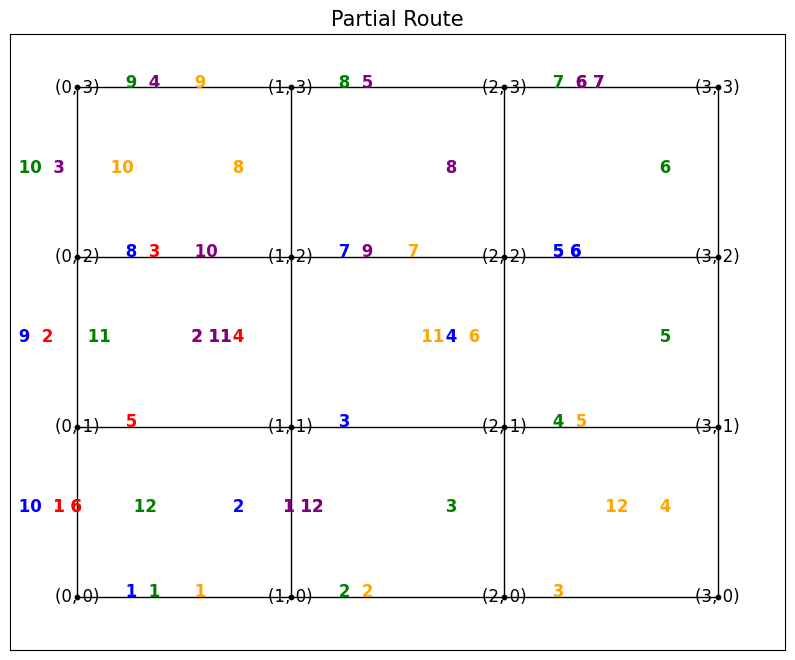

In [80]:
def plot_routes(route):
    colors = ['blue', 'red', 'green', 'purple', "orange", "brown", "pink", "yellow", "grey", "cyan"]
    nx.set_edge_attributes(G,"", "plot_sequence")

    plt.figure(figsize=(10, 8))
    nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True)

    for color, route in enumerate(routes):
        visited = []
        for i, edge in enumerate(route):
            # if we've visited the arc already on this route, add to plot_sequence. otherwise create new
            if((edge[0], edge[1]) not in visited and (edge[1], edge[0]) not in visited):
                new_plot_sequence = ""
                for j in range(len(G[edge[0]][edge[1]]["plot_sequence"])):
                    new_plot_sequence += "  "
                G[edge[0]][edge[1]]['plot_sequence'] = new_plot_sequence + ' ' + str(i+1)
            else:
                G[edge[0]][edge[1]]['plot_sequence'] += ' ' + str(i+1)
            visited.append(edge)
        for edge in route:
            x = (node_positions[edge[0]][0] + node_positions[edge[1]][0]) / 2 - .3
            y = (node_positions[edge[0]][1] + node_positions[edge[1]][1]) / 2
            plt.text(x, y, G[edge[0]][edge[1]]["plot_sequence"], color=colors[color], fontsize=12, fontweight = 'bold')
    plt.title('Partial Route', size=15)
    plt.show()

plot_routes(routes)